In [8]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import json
import glob as glob
import os
%matplotlib inline

# FUSE Client

1 server and 2 clients

In [9]:
def to_seconds(timestamp):
    ts = timestamp.split(':')
    return float(float(ts[0])*60*60 + float(ts[1])*60 + float(ts[2]))

def parse_mdtest(files):
    r = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)
            for line in data['stdout_lines']:
                if "started" in line: start = line.split()[4]
                if "finished" in line: end = line.split()[4]
            r.append(to_seconds(end) - to_seconds(start))
    return r

def parse_delta(files):
    r = []
    o = []
    for fname in sorted(files):
        with open(fname) as f:
            data = json.load(f)       
            r.append(to_seconds(data['delta']))
            try:
                o.append(float(data['stdout']))
            except:
                o.append(0)
    return r, o

(0, 200000)

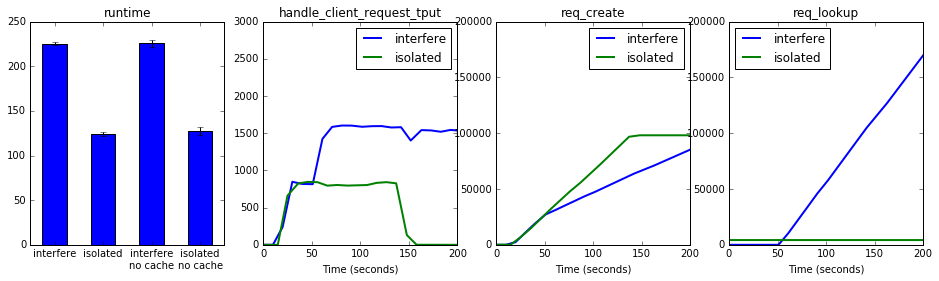

In [10]:
# plot runtimes
df = pd.DataFrame(columns=["job", "mean", "std"])
site = 'experiments/fuse/consistency/results-old/nojournal-cache/mdtest-'
for job in ["interfere", "isolated"]:
    d = parse_mdtest(glob.glob(site + job + '*'))
    df.loc[len(df)] = [job, np.mean(d), np.std(d)]
    
site = 'experiments/fuse/consistency/results-old/nojournal-nocache/mdtest-'
for job in ["interfere", "isolated"]:
    d = parse_mdtest(glob.glob(site + job + '*'))
    df.loc[len(df)] = [job + "\nno cache", np.mean(d), np.std(d)]

fig, ax = plt.subplots(1, 4, figsize=(16, 4))

df.plot.bar(ax=ax[0], y='mean', yerr='std')
ax[0].set_xticklabels(df['job'], rotation=0)
ax[0].legend().remove()
ax[0].set_title("runtime")


# plot the throughputs
s = 'experiments/fuse/consistency/results-old/nojournal-cache/'
init = 0

# format: (name, axes, xshift, yshift)
for metric in [("handle_client_request_tput", 1, 300, 0),
               ("req_create", 2, 300, 100000),
               ("req_lookup", 3, 300, 210000)]:
    df = pd.read_csv(s + metric[0] + '.wsp.out', skiprows=13, names=["index", "time", metric[0]])
    df = df[df['time'] != 0]                  # filter out null timestamps
    if init == 0:
        init = float(df['time'].loc[0])       # beginning of runs shifted to 0 (unix time stamp)
    #df = df.drop(df.index[range(0, 50)])     # drop some values to line up start times
    shft = df['index'].iloc[0]                # shift timestamps to 0
    df['x'] = df['time'] - init - shft        # specify values for x axis
    df.plot(ax=ax[metric[1]], x='x', y=metric[0], lw=2, label='interfere')
    #df1 = df.drop(df.index[range(0, 30)])
    df1 = df
    df1['x'] = df['x'] - metric[2]
    df1[metric[0]] = df1[metric[0]] - metric[3]
    df1.plot(ax=ax[metric[1]], x='x', y=metric[0], lw=2, label='isolated')
    ax[metric[1]].set_title(metric[0])
    ax[metric[1]].set_xlabel('Time (seconds)')
    ax[metric[1]].set_xlim(0, 200) 

ax[1].set_ylim(0, 3000)
ax[2].set_ylim(0, 200000)
ax[3].set_ylim(0, 200000)

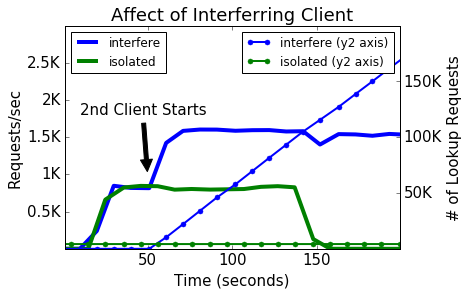

In [51]:
fig, ax = plt.subplots(1, 1)
s = 'experiments/fuse/consistency/results-old/nojournal-cache/'
init = 0

#for metric in [("handle_client_request_tput", 1, 300, 0)]:
df = pd.read_csv(s + 'handle_client_request_tput' + '.wsp.out', skiprows=13, names=["index", "time",'handle_client_request_tput'])

df = df[df['time'] != 0]                  # filter out null timestamps
if init == 0:
    init = float(df['time'].loc[0])       # beginning of runs shifted to 0 (unix time stamp)
#df = df.drop(df.index[range(0, 50)])     # drop some values to line up start times
shft = df['index'].iloc[0]                # shift timestamps to 0
df['x'] = df['time'] - init - shft        # specify values for x axis
df.plot(ax=ax, x='x', y='handle_client_request_tput', lw=4, label='interfere')
df1 = df
df1['x'] = df['x'] - 300
df1['handle_client_request_tput'] = df1['handle_client_request_tput'] - 0
df1.plot(ax=ax, x='x', y='handle_client_request_tput', lw=4, label='isolated')
ax.set_yticklabels(['', '0.5K', '1K', '1.5K', '2K', '2.5K', ''])
ax.set_title('Affect of Interferring Client')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Requests/sec')
ax.set_ylim(0, 3000)
ax.legend(loc='upper left', fontsize=12)

ax2 = ax.twinx()
("req_lookup", 3, 300, 210000)
df = pd.read_csv(s + 'req_lookup.wsp.out', skiprows=13, names=["index", "time", 'req_lookup'])
df = df[df['time'] != 0]                  # filter out null timestamps
shft = df['index'].iloc[0]                # shift timestamps to 0
df['x'] = df['time'] - init - shft        # specify values for x axis
df.plot(ax=ax2, x='x', y='req_lookup', marker='.', ms=10, lw=2, label='interfere (y2 axis)')

df1 = df
df1['x'] = df['x'] - 300
df1['req_lookup'] = df1['req_lookup'] - 210000
df1.plot(ax=ax2, x='x', y='req_lookup', marker='.', ms=10, lw=2, label='isolated (y2 axis)')

ax2.legend(loc='upper right', fontsize=12)
ax2.set_ylabel('# of Lookup Requests')
ax2.set_xlim(1, 199) 
ax2.set_ylim(1, 200000)
vals = ax2.get_yticks()
ax2.set_yticklabels(['{:3.0f}K'.format(x/1000) for x in vals])
ax2.set_yticklabels(['', '50K', '100K', '150K', ''])


# add arrow
ax.annotate('2nd Client Starts', fontsize=15, xy=(50, 1000), xytext=(10, 1800),
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='middle',
            )
font = {'size'   : 15}
matplotlib.rc('font', **font)
fig.savefig('paper/graphs/behavior-interfere.png', dpi=400)

# Scale Clients

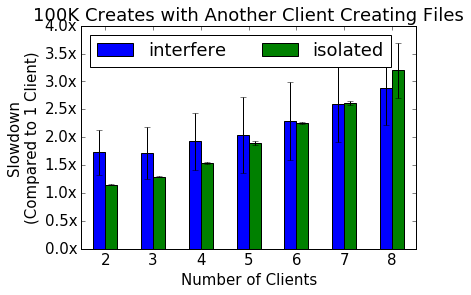

In [45]:
fig, ax = plt.subplots(1, 1)

# baseline: 100K isolated creates
site = 'experiments/fuse/consistency/results-old/nojournal-nocache/mdtest*'
base = parse_mdtest(glob.glob(site + 'isolated-9800*'))
norm = np.mean(base)

# client scaling experiment
mean = pd.DataFrame(columns=["interfere", "isolated"])
stds = pd.DataFrame(columns=["interfere", "isolated"])
for n in [2, 3, 4, 5, 6, 7, 8]:
    site = 'experiments/fuse/scale-clients/results-touchstream/creates-*'+str(n)+'*/*/mdtest-'
    interfer = parse_mdtest(glob.glob(site + 'interfere-9800*'))
    isolated = parse_mdtest(glob.glob(site + 'isolated-9800*'))
    mean.loc[len(mean)] = [np.mean(interfer/norm), np.mean(isolated/norm)]
    stds.loc[len(stds)] = [np.std(interfer/norm), np.std(isolated/norm)]
mean.plot.bar(ax=ax, yerr=stds)
ax.set_xticklabels(range(2, 9), rotation=0)
ax.set_title("100K Creates with Another Client Creating Files")
ax.set_xlabel("Number of Clients")
ax.set_ylabel("Slowdown\n(Compared to 1 Client)")
ax.legend(loc='upper left', ncol=2)
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}x'.format(x*1) for x in vals])
mean
fig.savefig('paper/graphs/slowdown-interfere.png', dpi=400)

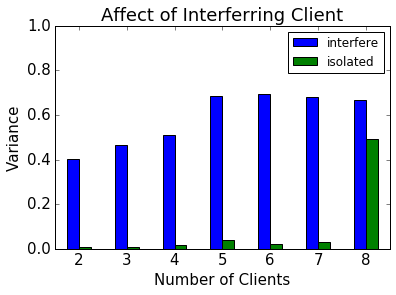

In [53]:
fig, ax = plt.subplots(1, 1)
stds.plot.bar(ax=ax)
ax.legend(fontsize=12)
ax.set_xticklabels(range(2, 9), rotation=0)
ax.set_title("Affect of Interferring Client")
ax.set_xlabel("Number of Clients")
ax.set_ylabel("Variance")
ax.set_ylim(0, 1)
fig.savefig('paper/graphs/slowdown-interfere.png', dpi=400)

/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/opt/conda/envs/python2/lib/python2.7/site-packages/numpy/core/_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


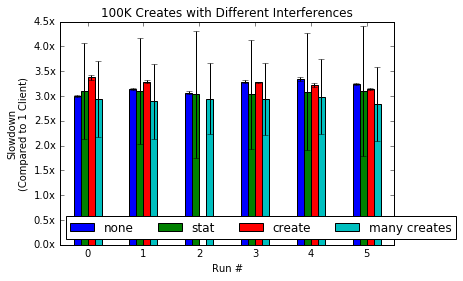

In [7]:
fig, ax = plt.subplots(1, 1)

# baseline: 100K isolated creates
site = 'experiments/fuse/consistency/results-old/nojournal-nocache/mdtest*'
base = parse_mdtest(glob.glob(site + 'isolated-9800*'))
norm = np.mean(base)

# client interference
mean = pd.DataFrame(columns=["none", "stat", "create", "many creates"])
stds = pd.DataFrame(columns=["none", "stat", "create", "many creates"])
for n in [0, 1, 2, 3, 4, 5]:
    m = []
    s = []
    for exp in ["creates", "creates-stat", "creates-touch", "creates-touchstream"]:
        site = 'experiments/fuse/scale-clients/results-diff-interference/'+exp+'-7/run'+str(n)+'/mdtest-*-98000*'
        data = parse_mdtest(glob.glob(site))
        m.append(np.mean(data/norm))
        s.append(np.std(data/norm))
    mean.loc[len(mean)] = m
    stds.loc[len(stds)] = s

mean.plot.bar(ax=ax, yerr=stds)
ax.set_xticklabels(range(0, 9), rotation=0)
ax.set_title("100K Creates with Different Interferences")
ax.legend(loc='lower left', ncol=4)
ax.set_xlabel("Run #")
ax.set_ylabel("Slowdown\n(Compared to 1 Client)")
vals = ax.get_yticks()
ax.set_yticklabels(['{:3.1f}x'.format(x*1) for x in vals])
fig.savefig('paper/graphs/slowdown-interfere-types.png', dpi=400)